# Lab03: Logistic Regression.

- Student ID: 20127370
- Student name: Mai Quý Trung

**How to do your homework**


You will work directly on this notebook; the word `TODO` indicate the parts you need to do.

You can discuss ideas with classmates as well as finding information from the internet, book, etc...; but *this homework must be your*.

**How to submit your homework**

Before submitting, rerun the notebook (`Kernel` ->` Restart & Run All`).

Then create a folder named `ID` (for example, if your ID is 1234567, then name the folder `1234567`). Copy file notebook to this folder, compress and submit it on moodle.

**Contents:**
- Logistic Regression.

## 1. Feature Extraction

### Import Library

In [1]:
using Flux, Images, MLDatasets, Plots
using Statistics, Distributions
using MLJ 
gr()

Plots.GRBackend()

### Load data

In [2]:
train_x, train_y = MNIST.traindata(Int64);
test_x, test_y = MNIST.testdata(Int64);

train_x_flatten = Flux.flatten(train_x)'
test_x_flatten = Flux.flatten(test_x)'

size(train_x_flatten), size(train_y), size(test_x_flatten), size(test_y)

┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets /Users/quytrungg/.julia/packages/MLDatasets/A3giY/src/datasets/vision/mnist.jl:187
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/quytrungg/.julia/packages/MLDatasets/A3giY/src/datasets/vision/mnist.jl:195


((60000, 784), (60000,), (10000, 784), (10000,))

### Extract Features

So we basically have 70000 samples with each sample having 784 features - pixels in this case and a label - the digit the image represent.

Let’s play around and see if we can extract any features from the pixels that can be more informative. First I’d like to know more about average intensity - that is the average value of a pixel in an image for the different digits

In [3]:
function compute_average_intensity(x, y)
    mean = zeros(10) # 10 is number of labels
    #TODO compute average intensity for each label
    count = zeros(10)
    for i in 1:length(y)
        count[y[i]+1] += 1
    end

    for i in 1:length(y)
        mean[y[i]+1] += sum(x[i, :])
    end

    for i in 1:10
        mean[i] /= count[i]
    end
    return mean
end

l_mean = compute_average_intensity(train_x_flatten, train_y);

Plot the average intensity using matplotlib

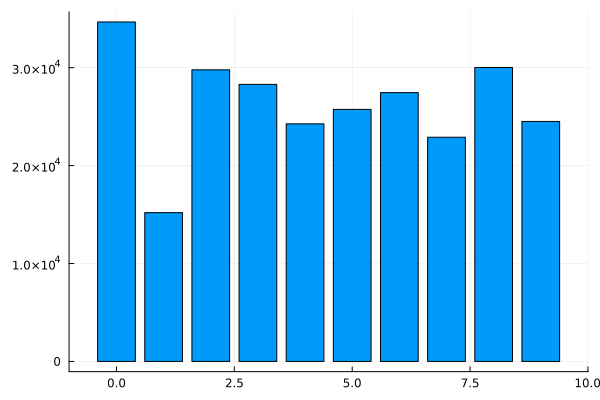

In [4]:
bar(0:9, l_mean, legend=false)

As we can see there are some differences in intensity. The digit “1” is the less intense while the digit “0” is the most intense. So this new feature seems to have some predictive value if you wanted to know if say your digit is a “1” or not.

In [5]:
#TODO compute average intensity for each data sample
intensity = mean(train_x_flatten, dims=2)
size(intensity)

(60000, 1)

Some digits are symmetric (1, 3, 8, 0) some are not (2, 4, 5, 6, 9). Creating a new feature capturing this could be useful. Specifically, we calculate $s = -\frac{s_1 + s_2}{2}$ for each image:
- $s_1$: flip the image along y-axis and compute the mean value of result
- $s_2$: flip the image along x-axis and compute the mean value of result

In [6]:
function compute_symmetry(train_x)
    symmetry = []
    for i in 1:size(train_x)[1]
        img = reshape(train_x[i,:], (28,28))
        s1 = mean(abs.(img - reverse(img, dims=1)))
        s2 = mean(abs.(img - reverse(img, dims=2)))
        s = -0.5 .* (s1 + s2)
        append!(symmetry, s)
    end
    return symmetry
end

symmetry = compute_symmetry(train_x_flatten)
size(symmetry)

(60000,)

Visualize 10 samples in order to illustrate symmetry

,,,,,,,,,

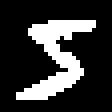
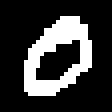
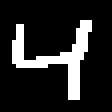
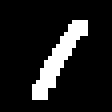
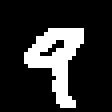
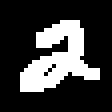
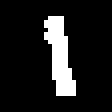
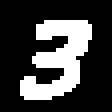
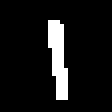
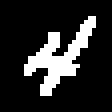

In [7]:
num_img = 10
img_flat = train_x_flatten[1:num_img,:]
img = [reshape(img_flat[i,:], (28,28))' for i in 1:num_img]
[colorview(Gray, Float32.(img[i])) for i in 1:num_img]

,,,,,,,,,

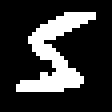
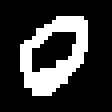
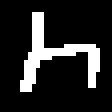
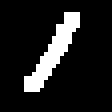
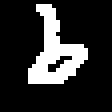
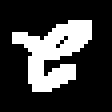
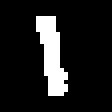
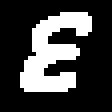
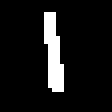
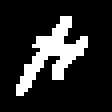

In [8]:
img_reverse_flat = reverse(img_flat, dims=2)
img_reverse = [reshape(img_reverse_flat[i,:], (28,28))' for i in 1:num_img]
[colorview(Gray, Float32.(img_reverse[i])) for i in 1:num_img]

Our new training data will have 60000 samples and 2 features: intensity, symmetry.

In [9]:
#TODO create X_new by horizontal stack intensity and symmetry
train_x_new = hcat(intensity, symmetry)
size(train_x_new)

(60000, 2)

## 2. Training 

Usually logistic regression is a good first choice for classification. In this homework we use logistic regression for classifying digit 1 images and not digit 1's images.

### Normalize data

In data process, you will first process training data. The parameter obtained in the process will be reused for processing test set

First normalize data using Z-score normalization
- **TODO: Study about Z-score normalization**
    - Z-score (also called standard score) is a measure of how many std below or above the mean a raw data is.
    - Equation: $z = \frac{x - \bar{A}}{\sigma}$
    - $\bar{A}$ is mean
    - ${\sigma}$ is standard deviation
- **TODO: Why should we normalize data?**

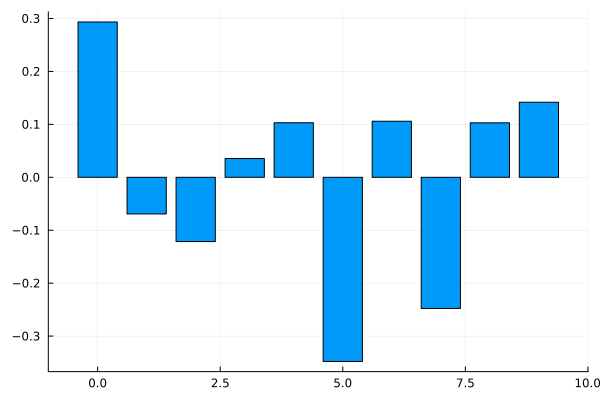

In [10]:
function normalize(x_train, mean_=nothing, std_=nothing)
    if mean_ == nothing && std_ == nothing
        #TODO normalize x_train
        #return `normalized_train_x`, `mean_`, `std_`
        #mean_ and std_ will be re-used to pre-process test set
        mean_ = mean(x_train, dims=1)
        std_ = std(x_train, dims=1)
        z_score = (x_train .- mean_) ./ std_
        return z_score, mean_, std_
    end
    return (x_train .- mean_) ./ std_
end

normalized_train_x, mean_, std_ = normalize(train_x_new)

s_mean = compute_average_intensity(normalized_train_x, train_y)
bar(0:9, s_mean, legend=false)

### Construct  data

In [11]:
# change the label: y=1 -> stay unchanged, y!=1 -> y=0
train_y_new = reshape(deepcopy(train_y), (size(train_y)[1], 1))
train_y_new[train_y_new .!= 1] .= 0
size(train_y_new)

(60000, 1)

In [12]:
# contruct data by adding ones
add_one_train_x = hcat(ones(size(normalized_train_x)[1],), normalized_train_x)
size(add_one_train_x)

(60000, 3)

### Sigmoid function and derivative of the sigmoid function

In [13]:
function sigmoid_activation(x)
    """
    Compute the sigmoid activation value for a given input
    """
    return 1.0 ./ (1.0 .+ exp.(-x))
end

function sigmoid_deriv(x)
    """
    Compute the derivative of the sigmoid function ASSUMING
    that the input 'x' has already been passed through the sigmoid
    activation function
    """
    return x .* (1 .- x)
end

sigmoid_deriv (generic function with 1 method)

### Compute output

In [14]:
function compute_h(W, X)
    """
    Compute output: Take the inner product between our features 'X' and the weight
    matrix 'W', then pass this value through our sigmoid activation function 
    """
    return X*W
end

function predict(W, X)
    """
    Take the inner product between our features and weight matrix, 
    then pass this value through our sigmoid activation
    """
    preds = sigmoid_activation(compute_h(W, X))

    # apply a step function to threshold the outputs to binary
    # class labels
    preds[preds .<= 0.5] .= 0
    preds[preds .> 0] .= 1

    return preds
end

predict (generic function with 1 method)

### Compute gradient

**Loss Function: Average negative log likelihood**
$$\mathcal{L}=\dfrac{1}{N} \sum_{i=1}^{N} -\left(y^{i}\ln h_{\mathbf{w}}\left(\mathbf{x}^{i}\right)+\left(1-y^{i}\right)\ln \left(1-h_{\mathbf{w}}\left(x^{i}\right)\right)\right) $$


$$\text{Sigmoid Activation: } z= \sigma \left(h\right)= \dfrac{1}{1+e^{-h}}$$

$$\text{Cross-entropy: } J(w)=-\left({ylog(z)+(1-y)log(1-z)}\right)$$

$$\text{Chain rule: } \dfrac{\partial J(w)}{\partial w}=\dfrac{\partial J(w)}{\partial z} \dfrac{\partial z}{\partial h}\dfrac{\partial h}{\partial w}  $$

$$\dfrac{\partial J(w)}{\partial z}=-\left(\dfrac{y}{z}-\dfrac{1-y}{1-z}\right)=\dfrac{z-y}{z(1-z)}$$

$$\dfrac{\partial z}{\partial h}=z(1-z)$$

$$\dfrac{\partial h}{\partial w}=X$$

$$\dfrac{\partial J(w)}{\partial w}=X^T(z-y)$$

In [15]:
function compute_gradient(error, train_x)
    """
    the gradient descent update is the dot product between our
    features and the error of the sigmoid derivative of
    our predictions
    """
    #TODO compute gradient
    gradient = train_x' * error
    return gradient
end

compute_gradient (generic function with 1 method)

In [16]:
function train(W, train_x, train_y, learning_rate, num_epochs)
    losses = []
    for epoch in 1:num_epochs
        y_hat = sigmoid_activation(compute_h(W, train_x))
        error = y_hat - train_y
        append!(losses, mean(-1 .* train_y .* log.(y_hat) .- (1 .- train_y) .* log.(1 .- y_hat)))
        grad = compute_gradient(error, train_x)
        W -= learning_rate * grad

        if epoch == 1 || epoch % 50 == 0
            print("Epoch=$epoch; Loss=$(losses[end])\n")
        end
    end
    return W, losses
end

train (generic function with 1 method)

### Train our model

In [24]:
W = rand(Normal(), (size(add_one_train_x)[2], 1))

num_epochs=2000
learning_rate=0.01
W, losses = train(W, add_one_train_x, train_y_new, learning_rate, num_epochs);

Epoch=1; Loss=0.8880910908428759
Epoch=50; Loss=NaN


Epoch=100; Loss=NaN
Epoch=150; Loss=NaN


Epoch=200; Loss=NaN
Epoch=250; Loss=NaN


Epoch=300; Loss=NaN
Epoch=350; Loss=NaN


Epoch=400; Loss=NaN
Epoch=450; Loss=NaN


Epoch=500; Loss=NaN
Epoch=550; Loss=NaN


Epoch=600; Loss=NaN
Epoch=650; Loss=NaN


Epoch=700; Loss=NaN
Epoch=750; Loss=NaN


Epoch=800; Loss=NaN
Epoch=850; Loss=NaN


Epoch=900; Loss=NaN
Epoch=950; Loss=NaN


Epoch=1000; Loss=NaN
Epoch=1050; Loss=NaN


Epoch=1100; Loss=NaN
Epoch=1150; Loss=NaN


Epoch=1200; Loss=NaN
Epoch=1250; Loss=NaN


Epoch=1300; Loss=NaN
Epoch=1350; Loss=NaN


Epoch=1400; Loss=NaN
Epoch=1450; Loss=NaN


Epoch=1500; Loss=NaN
Epoch=1550; Loss=NaN


Epoch=1600; Loss=NaN
Epoch=1650; Loss=NaN


Epoch=1700; Loss=NaN
Epoch=1750; Loss=NaN


Epoch=1800; Loss=NaN
Epoch=1850; Loss=NaN


Epoch=1900; Loss=NaN
Epoch=1950; Loss=NaN


Epoch=2000; Loss=NaN


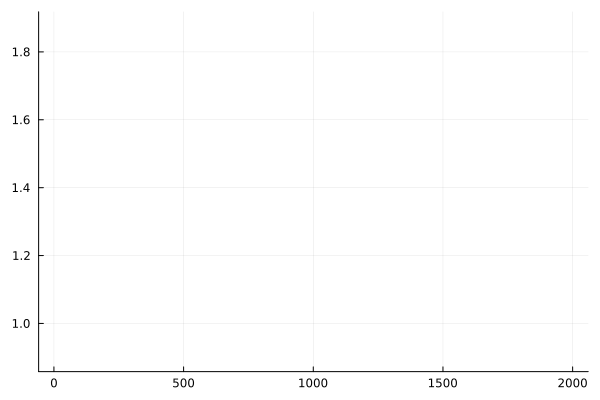

In [25]:
plot(1:num_epochs, losses, legend=false)

## 3. Evaluate our model

In this section, you will evaluate your model on train set and test set and make some comment about the result.

### Evaluate model on training set

In [26]:
preds_train = predict(W, add_one_train_x)

train_y_new = reshape(train_y_new, length(train_y_new), 1)
acc = accuracy(preds_train, train_y_new)
p = precision(preds_train, train_y_new)
r = recall(preds_train, train_y_new)
f1 = 2*p*r/(p + r)

print(" acc: $acc\n precision: $p\n recall: $r\n f1_score: $f1\n")

 acc: 0.8918
 precision: 0.9734848484848485
 recall: 0.038119252447345
 f1_score: 0.07336568655438197


┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /Users/quytrungg/.julia/packages/MLJBase/U4Dis/src/measures/confusion_matrix.jl:116
┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /Users/quytrungg/.julia/packages/MLJBase/U4Dis/src/measures/confusion_matrix.jl:116


### Evaluate model on test set

In order to predict the result on test set, you have to perform data pre-process first. The pre-process is done exactly what we have done on train set. That means, you have to:

- Change the label in `test_y` to `0` and `1` and store in a new variable named `test_y_new`
- Calculate `test_intensity` and `test_symmetry` to form `test_x_new` (the shape should be `(10000,2)`)
- Normalized `test_x_new` by z-score. Note the you will re-use variable `mean_` and `std_` to calculate `test_x_new` instead of compute new ones. You will store the result in `normalized_test_x`
- Add a column that's full of one to `test_x_new` and store in `add_one_test_x` (the shape should be `(10000,3)`)

In [27]:
#TODO

# compute test_y_new
test_y_new = reshape(deepcopy(test_y), (size(test_y)[1], 1))
test_y_new[test_y_new .!= 1] .= 0

# compute test_intensity and test_symmetry to form test_x_new
test_intensity = mean(test_x_flatten, dims=2)
test_symmetry = compute_symmetry(test_x_flatten)
test_x_new = hcat(test_intensity, test_symmetry)

# normalize test_x_new to form normalized_test_x
normalized_test_x = normalize(test_x_new, mean_, std_)

# add column `ones` to test_x_new
add_one_test_x = hcat(ones(size(normalized_test_x)[1],), normalized_test_x)
size(add_one_test_x)

(10000, 3)

After doing all these stuffs, you now can predict and evaluate your model

In [29]:
preds_test = predict(W, add_one_test_x)

test_y_new = reshape(test_y_new, length(test_y_new), 1)
acc = accuracy(preds_test, test_y_new)
p = precision(preds_test, test_y_new)
r = recall(preds_test, test_y_new)
f1 = 2*p*r/(p + r) #**TODO: Comment on the result**

print(" acc: $acc\n precision: $p\n recall: $r\n f1_score: $f1\n")

 acc: 0.8905
 precision: 0.8846153846153846
 recall: 0.04052863436123348
 f1_score: 0.07750631844987364


┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /Users/quytrungg/.julia/packages/MLJBase/U4Dis/src/measures/confusion_matrix.jl:116
┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /Users/quytrungg/.julia/packages/MLJBase/U4Dis/src/measures/confusion_matrix.jl:116


**TODO: Comment on the result**
- At first glance, the model's prediction on train data and test data has a very high accuracy, with 89.18% on train data and 89.05% on test data.
- In details, the model's precision percentage on train and test data is also very high (> 88%), which means that everytime the model predicts a data sample to be number 1 (label 1), the high chance that prediction is correct.
- On the other hand, the model's recall percentage is below 4% on train and test data, which means the percentage of the model recognizing a data sample to be number 1 (label 1) is not that high, many number 0s data is predicted to be number 1 by the model.
- Overall, since the precision is high and recall is low, the f1_score (calculated by the artihmetic mean of its precision and recall) is also below 10% (approximately 7.5% on both train and test data).
- The final conclusion of this model using logistic regression method above is that the accuracy of predicting number 1s data (label 1) is very high, meanwhile, if there are many not-number 1s data (label 0) in the data, chances are the model does not perform well on recognizing between label 1 and label 0 data.